# Face recognition with Keras

In [1]:
import cv2
import random
import os.path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# align_dlib is a file from OpenFace, downloaded here: https://github.com/cmusatyalab/openface/blob/master/openface/align_dlib.py
import align_dlib 

# To install dlib
#!apt update
#!apt install -y cmake
#!pip install dlib

We will build a face recognition system. The code largely comes from a course project at Efrei Paris, for an artificial intelligence course, and was made in 2018.

The code follows the architecture described in the [article "FaceNet: A Unified Embedding for Face Recognition and Clustering"](https://arxiv.org/abs/1503.03832) (2015).

The faces used come from the database [Labeled Faces in the Wild Home of the University of Massachusetts]((http://vis-www.cs.umass.edu/lfw/)).

# Introduction - Principle of face recognition

Face recognition applications such as proving an identity in an airport, find someone among many video surveillance recording or simply unlocking a phone. This domain has evolved quickly in recent years, especially since 2014 with the rise of the deep learning.

The process to recognize faces can be divided in 4 steps:

![Face recognition process](face-recognition-process.png)

1. **Detect the face** inside the image, thanks to a deep learning detector that has been trained to find faces inside images.
2. **Align and crop the face**, based on the position of the keypoints of the face (eyes, mouse, nose, etc.).
3. **Compute a representation of the face**, with a convolutional neural network that creates an embedding of the face.
4. **Identify the face** by comparing the embedding with the ones we have in database.

In this tutorial, we will do the steps 1 and 2 by using some code from the project [*OpenFace*](https://github.com/cmusatyalab/openface), which is based on *dlib*, a C++ engine to detect the face and its keypoints. For the step 3, we will implement a convolutional neural network with *Keras*. To finish, for the step 4, we will build a SVM model with *Scikit-Learn* to classify the face.

# 1. Data preparation - Detect and crop the face

## 1.1. Load the metadata of the faces

The faces come from the database Labeled Faces in the Wild Home of the University of Massachusetts (see the [database presentation](http://vis-www.cs.umass.edu/lfw/)).

In [2]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        self.base = base
        self.name = name
        self.file = file

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('images2')

In [3]:
def load_image(path):
    img = cv2.imread(path)
    # OpenCV loads images with color channels in BGR order, so we need to reverse them, in order to get RGB.
    return img[...,::-1]

## 1.2. Load the model detecting the landmarks on faces

We will use a detector that detects 68 landmarks on faces. These landmarks represent keypoints of the face, and permit to align and crop the face correctly in a way that some keypoints are located at the exact same position between multiple faces. This is necessary to later compare the faces.

Illustration of the points location ([source](https://www.pyimagesearch.com/2018/04/02/faster-facial-landmark-detector-with-dlib/))
![68-points detector](images_illustation/68-points-detector.png)

The 68-points come from the dataset [iBUG 300-W](https://ibug.doc.ic.ac.uk/resources/facial-point-annotations/), on which the detector has been trained. In the model, each point is numbered and represents a specific landmark, especially the eyes, nose, mouth, eyebrows and facial contours.

![68-points repartition](images_illustation/68-points-repartition.png)

We download the pre-trained 68-points `dlib model` and save it under *models/landmarks.dat* ([direct dowload from lib.net](http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2)).

## 1.3. Detect and crop the faces

Thanks to this pre-trained `dlib model`, we will detect, align and crop our faces in the images. The `dlib model` is accessed via the wrappring class `AlignDlib` from `OpenFace`. [OpenFace](https://github.com/cmusatyalab/openface) is an open source face recognition API built with deep neural networks. Its class `AlignDlib` uses `dlib` to detect the faces and crop it according to its keypoints.

OpenFace 0.2.0 ([source](http://bamos.github.io/2016/01/19/openface-0.2.0/))

![Visage dection with OpenFace](images_illustation/open-face.png)

In [4]:
FACE_IMG_SIZE = 96
EMBEDDING_VECTOR_SIZE = 128

# We list the 3 keypoints we will use to align the faces
INNER_EYES_AND_BOTTOM_LIP = [39,42,57] # [left_eye_nearest_point_to_the_nose, right_eye_nearest_point_to_the_nose, lips_bottom_point]
OUTER_EYES_AND_NOSE = [36,45,33] # [left_eye_nearest_point_to_the_ear, right_eye_nearest_point_to_the_ear, nose_bottom_point]

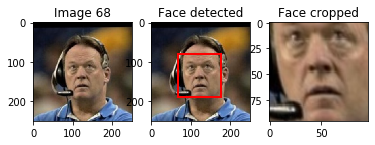

In [5]:
# Load a random image
img_number = random.randint(0,99)
img_orig = load_image(metadata[img_number].image_path())

# Detect face and return bounding box 
al = align_dlib.AlignDlib('models/landmarks.dat')
bb = al.getLargestFaceBoundingBox(img_orig) 

# Transform image using the face landmark indices for OUTER_EYES_AND_NOSE and crop image to FACE_IMG_SIZE x FACE_IMG_SIZE pixels
img_aligned = al.align(imgDim=FACE_IMG_SIZE, rgbImg=img_orig, bb=bb, landmarks=None, landmarkIndices=OUTER_EYES_AND_NOSE, skipMulti=False)

# Show original image
plt.subplot(131)
plt.imshow(img_orig)
plt.title("Image " + str(img_number))

# Show original image with bounding box
plt.subplot(132)
plt.imshow(img_orig)
rect_format = patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red', linewidth=2) #DONE
plt.gca().add_patch(rect_format) # draw a rectangle around the face, corresponding to the bounding box
plt.title("Face detected")

# Show aligned image
plt.subplot(133)
plt.imshow(img_aligned)
plt.title("Face cropped")
plt.show()

# 2. Compute the face embedding

Once the faces are extracted, we will use a CNN in order to transform the face into a vector of 128 pixels in a way that the vector will be as much representative of the face as possible. 

The CNN network will then be trained in a way that two faces of the same person have two near vectors and two faces of two different persons have two far vectors. 

Representation of the distanciation between the vectors ([source](http://bamos.github.io/2016/01/19/openface-0.2.0/))

![face-distance-vectors](images_illustation/face-distance-vectors.png)

## 2.1. Define the convolutional neural network

The architecture of the model is a variant of the NN4 architecture described in the [FaceNet paper](https://arxiv.org/abs/1503.03832) and identified as [nn4.small2](https://cmusatyalab.github.io/openface/models-and-accuracies/#model-definitions) model in the OpenFace project.

We build the different layers from this architecture schema ([source](https://raw.githubusercontent.com/krasserm/face-recognition/master/model.png)):
![Complete model](images_illustation/model.png)

We implement the model in Keras, as in the [Keras-OpenFace](https://github.com/iwantooxxoox/Keras-OpenFace) project.

In [6]:
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Layer
from keras.layers.core import Lambda, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D

## Defines a normalization layer that does not exist anymore in Keras
def LRN2D(x):
    return tf.nn.lrn(x, alpha=1e-4, beta=0.75)

Using TensorFlow backend.


The first layer is the most important one as it is from this layer that the 128-dimensional embedding vectors can be obtained:

In [7]:
# Here we use the functional API of Keras, see an example here: https://keras.io/getting-started/functional-api-guide/
def create_first_layers():
    myInput = Input(shape=(FACE_IMG_SIZE, FACE_IMG_SIZE, 3))

    x = ZeroPadding2D(padding=(3, 3))(myInput)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn1')(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x) 
    x = Lambda(LRN2D, name='lrn_1')(x)
    x = Conv2D(64, (1, 1), name='conv2')(x)
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn2')(x)
    x = Activation('relu')(x) 
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = Conv2D(192, (3, 3), name='conv3')(x) 
    x = BatchNormalization(axis=3, epsilon=0.00001, name='bn3')(x) 
    x = Activation('relu')(x) 
    x = Lambda(LRN2D, name='lrn_2')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D(pool_size=3, strides=2)(x) 

    return myInput, x

In [8]:
def create_inception_3a(x):
    inception_3a_3x3 = Conv2D(96, (1, 1), name='inception_3a_3x3_conv1')(x)
    inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn1')(inception_3a_3x3)
    inception_3a_3x3 = Activation('relu')(inception_3a_3x3)
    inception_3a_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3a_3x3) 
    inception_3a_3x3 = Conv2D(128, (3, 3), name='inception_3a_3x3_conv2')(inception_3a_3x3)
    inception_3a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_3x3_bn2')(inception_3a_3x3)
    inception_3a_3x3 = Activation('relu')(inception_3a_3x3)

    inception_3a_5x5 = Conv2D(16, (1, 1), name='inception_3a_5x5_conv1')(x)
    inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn1')(inception_3a_5x5)
    inception_3a_5x5 = Activation('relu')(inception_3a_5x5)
    inception_3a_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3a_5x5) 
    inception_3a_5x5 = Conv2D(32, (5, 5), name='inception_3a_5x5_conv2')(inception_3a_5x5)
    inception_3a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_5x5_bn2')(inception_3a_5x5)
    inception_3a_5x5 = Activation('relu')(inception_3a_5x5)

    inception_3a_pool = MaxPooling2D(pool_size=3, strides=2)(x)
    inception_3a_pool = Conv2D(32, (1, 1), name='inception_3a_pool_conv')(inception_3a_pool)
    inception_3a_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_pool_bn')(inception_3a_pool)
    inception_3a_pool = Activation('relu')(inception_3a_pool)
    inception_3a_pool = ZeroPadding2D(padding=((3, 4), (3, 4)))(inception_3a_pool)  

    inception_3a_1x1 = Conv2D(64, (1, 1), name='inception_3a_1x1_conv')(x)
    inception_3a_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3a_1x1_bn')(inception_3a_1x1)
    inception_3a_1x1 = Activation('relu')(inception_3a_1x1)

    inception_3a = concatenate([inception_3a_3x3, inception_3a_5x5, inception_3a_pool, inception_3a_1x1], axis=3)

    return inception_3a
  

In [9]:
def create_inception_3b(inception_3a):
    # Inception3b: reproduce Inception3a, but for the names of the layers: replace 'a' by 'b' in the names.
    inception_3b_3x3 = Conv2D(96, (1, 1), name='inception_3b')(inception_3a)
    inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn1')(inception_3b_3x3)
    inception_3b_3x3 = Activation('relu')(inception_3b_3x3)
    inception_3b_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3b_3x3)  
    inception_3b_3x3 = Conv2D(128, (3, 3), name='inception_3b_3x3_conv2')(inception_3b_3x3)
    inception_3b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_3x3_bn2')(inception_3b_3x3)
    inception_3b_3x3 = Activation('relu')(inception_3b_3x3)  
    
    inception_3b_5x5 = Conv2D(32, (1, 1), name='inception_3b_5x5_conv1')(inception_3a)
    inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn1')(inception_3b_5x5)
    inception_3b_5x5 = Activation('relu')(inception_3b_5x5)
    inception_3b_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3b_5x5)  
    inception_3b_5x5 = Conv2D(64, (5, 5), name='inception_3b_5x5_conv2')(inception_3b_5x5)
    inception_3b_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_5x5_bn2')(inception_3b_5x5)
    inception_3b_5x5 = Activation('relu')(inception_3b_5x5)

    inception_3b_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_3a) 
    inception_3b_pool = Conv2D(64, (1, 1), name='inception_3b_pool_conv')(inception_3b_pool)
    inception_3b_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_pool_bn')(inception_3b_pool)
    inception_3b_pool = Activation('relu')(inception_3b_pool)
    inception_3b_pool = ZeroPadding2D(padding=(4, 4))(inception_3b_pool) 
    
    inception_3b_1x1 = Conv2D(64, (1, 1), name='inception_3b_1x1_conv')(inception_3a)
    inception_3b_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3b_1x1_bn')(inception_3b_1x1)
    inception_3b_1x1 = Activation('relu')(inception_3b_1x1)

    inception_3b = concatenate([inception_3b_3x3, inception_3b_5x5, inception_3b_pool, inception_3b_1x1], axis=3)

    return inception_3b

In [10]:
def create_inception_3c(inception_3b):
  
    # Inception3c
    inception_3c_3x3 = Conv2D(128, (1, 1), name='inception_3c')(inception_3b)
    inception_3c_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3c_3x3_bn1')(inception_3c_3x3)
    inception_3c_3x3 = Activation('relu')(inception_3c_3x3)
    inception_3c_3x3 = ZeroPadding2D(padding=(1, 1))(inception_3c_3x3)
    inception_3c_3x3 = Conv2D(256, (3, 3), strides=(2, 2), name='inception_3c_3x3_conv2')(inception_3c_3x3)
    inception_3c_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3c_3x3_bn2')(inception_3c_3x3)
    inception_3c_3x3 = Activation('relu')(inception_3c_3x3)  

    inception_3c_5x5 = Conv2D(32, (1, 1), name='inception_3c_5x5_conv1')(inception_3b)
    inception_3c_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3c_5x5_bn1')(inception_3c_5x5)
    inception_3c_5x5 = Activation('relu')(inception_3c_5x5)
    inception_3c_5x5 = ZeroPadding2D(padding=(2, 2))(inception_3c_5x5)
    inception_3c_5x5 = Conv2D(64, (5, 5), strides=(2, 2), name='inception_3c_5x5_conv2')(inception_3c_5x5)
    inception_3c_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_3c_5x5_bn2')(inception_3c_5x5)
    inception_3c_5x5 = Activation('relu')(inception_3c_5x5)

    inception_3c_pool = MaxPooling2D(pool_size=3, strides=2)(inception_3b) 
    inception_3c_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_3c_pool)

    inception_3c = concatenate([inception_3c_3x3, inception_3c_5x5, inception_3c_pool], axis=3)

    return inception_3c

In [11]:
def create_inception_4a(inception_3c):
    #inception 4a
    inception_4a_3x3 = Conv2D(96, (1, 1), name='inception_4a')(inception_3c)
    inception_4a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_4a_3x3_bn1')(inception_4a_3x3)
    inception_4a_3x3 = Activation('relu')(inception_4a_3x3)
    inception_4a_3x3 = ZeroPadding2D(padding=(1, 1))(inception_4a_3x3)
    inception_4a_3x3 = Conv2D(192, (3, 3), name='inception_4a_3x3_conv2')(inception_4a_3x3)
    inception_4a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_4a_3x3_bn2')(inception_4a_3x3)
    inception_4a_3x3 = Activation('relu')(inception_4a_3x3) 
    
    inception_4a_5x5 = Conv2D(32, (1, 1), name='inception_4a_5x5_conv1')(inception_3c)
    inception_4a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_4a_5x5_bn1')(inception_4a_5x5)
    inception_4a_5x5 = Activation('relu')(inception_4a_5x5)
    inception_4a_5x5 = ZeroPadding2D(padding=(2, 2))(inception_4a_5x5)
    inception_4a_5x5 = Conv2D(64, (5, 5), name='inception_4a_5x5_conv2')(inception_4a_5x5)
    inception_4a_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_4a_5x5_bn2')(inception_4a_5x5)
    inception_4a_5x5 = Activation('relu')(inception_4a_5x5)

    inception_4a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_3c) #ligne donnée
    inception_4a_pool = Conv2D(128, (1, 1), name='inception_4a_pool_conv')(inception_4a_pool)
    inception_4a_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_4a_pool_bn')(inception_4a_pool)
    inception_4a_pool = Activation('relu')(inception_4a_pool)
    inception_4a_pool = ZeroPadding2D(padding=(2, 2))(inception_4a_pool)
    
    inception_4a_1x1 = Conv2D(256, (1, 1), name='inception_4a_1x1_conv')(inception_3c)
    inception_4a_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_4a_1x1_bn')(inception_4a_1x1)
    inception_4a_1x1 = Activation('relu')(inception_4a_1x1)
    
    inception_4a = concatenate([inception_4a_3x3, inception_4a_5x5, inception_4a_pool, inception_4a_1x1], axis=3)

    return inception_4a

In [12]:
def create_inception_4e(inception_4a):
    inception_4e_3x3 = Conv2D(160, (1, 1), name='inception_4e')(inception_4a)
    inception_4e_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_4e_3x3_bn1')(inception_4e_3x3)
    inception_4e_3x3 = Activation('relu')(inception_4e_3x3)
    inception_4e_3x3 = ZeroPadding2D(padding=(1, 1))(inception_4e_3x3)
    inception_4e_3x3 = Conv2D(256, (3, 3), strides=(2, 2), name='inception_4e_3x3_conv2')(inception_4e_3x3)
    inception_4e_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_4e_3x3_bn2')(inception_4e_3x3)
    inception_4e_3x3 = Activation('relu')(inception_4e_3x3) 
    
    inception_4e_5x5 = Conv2D(64, (1, 1), name='inception_4e_5x5_conv1')(inception_4a)
    inception_4e_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_4e_5x5_bn1')(inception_4e_5x5)
    inception_4e_5x5 = Activation('relu')(inception_4e_5x5)
    inception_4e_5x5 = ZeroPadding2D(padding=(2, 2))(inception_4e_5x5)
    inception_4e_5x5 = Conv2D(128, (5, 5), strides=(2, 2), name='inception_4e_5x5_conv2')(inception_4e_5x5)
    inception_4e_5x5 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_4e_5x5_bn2')(inception_4e_5x5)
    inception_4e_5x5 = Activation('relu')(inception_4e_5x5)
 
    inception_4e_pool = MaxPooling2D(pool_size=3, strides=2)(inception_4a)
    inception_4e_pool = ZeroPadding2D(padding=((0, 1), (0, 1)))(inception_4e_pool)

    inception_4e = concatenate([inception_4e_3x3, inception_4e_5x5, inception_4e_pool], axis=3)

    return inception_4e

In [13]:
def create_inception_5a(inception_4e):
    inception_5a_3x3 = Conv2D(96, (1, 1), name='inception_5a')(inception_4e)
    inception_5a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_5a_3x3_bn1')(inception_5a_3x3)
    inception_5a_3x3 = Activation('relu')(inception_5a_3x3)
    inception_5a_3x3 = ZeroPadding2D(padding=(1, 1))(inception_5a_3x3)
    inception_5a_3x3 = Conv2D(384, (3, 3), name='inception_5a_3x3_conv2')(inception_5a_3x3)
    inception_5a_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_5a_3x3_bn2')(inception_5a_3x3)
    inception_5a_3x3 = Activation('relu')(inception_5a_3x3) 

    inception_5a_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3))(inception_4e) 
    inception_5a_pool = Conv2D(96, (1, 1), name='inception_5a_pool_conv')(inception_5a_pool)
    inception_5a_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_5a_pool_bn')(inception_5a_pool)
    inception_5a_pool = Activation('relu')(inception_5a_pool)
    inception_5a_pool = ZeroPadding2D(padding=(1, 1))(inception_5a_pool) 
    
    inception_5a_1x1 = Conv2D(256, (1, 1), name='inception_5a_1x1_conv')(inception_4e)
    inception_5a_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_5a_1x1_bn')(inception_5a_1x1)
    inception_5a_1x1 = Activation('relu')(inception_5a_1x1)

    inception_5a = concatenate([inception_5a_3x3, inception_5a_pool, inception_5a_1x1], axis=3)

    return inception_5a

In [14]:
def create_inception_5b(inception_5a):
    inception_5b_3x3 = Conv2D(96, (1, 1), name='inception_5b')(inception_5a)
    inception_5b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_5b_3x3_bn1')(inception_5b_3x3)
    inception_5b_3x3 = Activation('relu')(inception_5b_3x3)
    inception_5b_3x3 = ZeroPadding2D(padding=(1, 1))(inception_5b_3x3)
    inception_5b_3x3 = Conv2D(384, (3, 3), name='inception_5b_3x3_conv2')(inception_5b_3x3)
    inception_5b_3x3 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_5b_3x3_bn2')(inception_5b_3x3)
    inception_5b_3x3 = Activation('relu')(inception_5b_3x3) 

    inception_5b_pool = MaxPooling2D(pool_size=3, strides=2)(inception_5a) 
    inception_5b_pool = Conv2D(96, (1, 1), name='inception_5b_pool_conv')(inception_5b_pool)
    inception_5b_pool = BatchNormalization(axis=3, epsilon=0.00001, name='inception_5b_pool_bn')(inception_5b_pool)
    inception_5b_pool = Activation('relu')(inception_5b_pool)
    inception_5b_pool = ZeroPadding2D(padding=(1, 1))(inception_5b_pool) 
    
    inception_5b_1x1 = Conv2D(256, (1, 1), name='inception_5b_1x1_conv')(inception_5a)
    inception_5b_1x1 = BatchNormalization(axis=3, epsilon=0.00001, name='inception_5b_1x1_bn')(inception_5b_1x1)
    inception_5b_1x1 = Activation('relu')(inception_5b_1x1)
    
    inception_5b = concatenate([inception_5b_3x3, inception_5b_pool, inception_5b_1x1], axis=3)

    return inception_5b

In [15]:
def create_model():
    myInput, x = create_first_layers()
    inception_3a = create_inception_3a(x)
    inception_3b = create_inception_3b(inception_3a)
    inception_3c = create_inception_3c(inception_3b)
    inception_4a = create_inception_4a(inception_3c)
    inception_4e = create_inception_4e(inception_4a)
    inception_5a = create_inception_5a(inception_4e)
    inception_5b = create_inception_5b(inception_5a)
    
    av_pool = AveragePooling2D(pool_size=(3, 3), strides=(1, 1))(inception_5b)
    reshape_layer = Flatten()(av_pool) 
    dense_layer = Dense(EMBEDDING_VECTOR_SIZE, name='dense_layer')(reshape_layer)
    norm_layer = Lambda(lambda  x: K.l2_normalize(x, axis=1), name='norm_layer')(dense_layer)

    return Model(inputs=[myInput], outputs=norm_layer)

In [16]:
nn4_small2 = create_model()

## 2.2. Train the model thanks to a siamese network

We will implement a [siamese neural network](https://en.wikipedia.org/wiki/Siamese_neural_network) in order to train our CNN. A siamese neural network is a network that works in tandem with two different input vectors generated by the same network (with the same weights) to compute a comparable output vectors. With backpropagation, the weights of the CNN will be updated depending of the results of the loss of the siamese neural network. 

The loss we will use is a **triplet loss**, that will compare an image, called an **anchor**, to a **positive** image (an image of the same class) and to a **negative** image (of a different class). The objective will be to find weights such that the embedding vector of the anchor is as close as possible to that of the positive and as far as possible from that of the negative.


Illustration of the triplet loss architecture ([source](https://towardsdatascience.com/image-similarity-using-triplet-loss-3744c0f67973)):
![Tiplet loss architecture](images_illustation/triplet-loss.png)

See an [implementation](https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d) of a Siamese network to classify characters to different alphabets Siamese network, and an [implementation](https://towardsdatascience.com/image-similarity-using-triplet-loss-3744c0f67973) of a triplet loss to compute image similarity.

In [17]:
# Input for anchor, positive and negative images
in_a = Input(shape=(FACE_IMG_SIZE, FACE_IMG_SIZE, 3))
in_p = Input(shape=(FACE_IMG_SIZE, FACE_IMG_SIZE, 3))
in_n = Input(shape=(FACE_IMG_SIZE, FACE_IMG_SIZE, 3))

# Output for anchor, positive and negative embedding vectors
# The nn4_small model instance is shared (Siamese network)
emb_a = nn4_small2(in_a)
emb_p = nn4_small2(in_p)
emb_n = nn4_small2(in_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

# Model trained with anchor, positive negative images
nn4_small2_train = Model([in_a, in_p, in_n], triplet_loss_layer)

We implement a `triplet_generator` function that creates batches of anchors, positive and negative images. The generator implementation is inspired by this [one](https://github.com/thelleland/Ex3/blob/b45bae55fbf36ce1ef3a6a434b5903be1394d466/generators.py).

In [19]:
def mk_triplets(directory):
    """ Returns a triplet composed of an anchor, positive and negative images """
    # List all the possible classes (the names in our databases) and all the images in our databases
    classes = os.listdir(directory)
    images = [os.listdir(os.path.join(directory,x)) for x in classes]

    while True:
        # pick random positive class, and random negative class
        pos_class = random.randint(0,len(classes)-1)
        neg_class = random.randint(0,len(classes)-2)
        if neg_class >= pos_class:
            neg_class = neg_class + 1

        # pick two random images from class
        anchor = os.path.join(directory, classes[pos_class], random.choice(images[pos_class]))
        pos    = os.path.join(directory, classes[pos_class], random.choice(images[pos_class]))
        neg    = os.path.join(directory, classes[neg_class], random.choice(images[neg_class]))

        yield (pos_class, neg_class, anchor, pos, neg)

In [20]:
from PIL import Image

def triplet_generator(batch_size, cache_size, directory):
    """ Generate batches of triplets [anchors, positive, negative] """
    trips = mk_triplets(directory)
    while True:
        ys = ans = pss = ngs = []
        for i in range(0,batch_size):
            pc, nc, anc, pos, neg = next(trips)
            ys.append((pc, nc))
            # We load the 3 images
            a_img = np.array(Image.open(anc))
            p_img = np.array(Image.open(pos))
            n_img = np.array(Image.open(neg))
            
            # We detect and crop the faces in the images
            a_img_aligned = al.align(imgDim=FACE_IMG_SIZE, rgbImg=a_img, bb=bb, landmarks=None, landmarkIndices=OUTER_EYES_AND_NOSE, skipMulti=False)
            a_img_aligned = np.asarray(a_img_aligned, dtype=np.float32)/255
            p_img_aligned = al.align(imgDim=FACE_IMG_SIZE, rgbImg=p_img, bb=bb, landmarks=None, landmarkIndices=OUTER_EYES_AND_NOSE, skipMulti=False)
            p_img_aligned = np.asarray(p_img_aligned, dtype=np.float32)/255
            n_img_aligned = al.align(imgDim=FACE_IMG_SIZE, rgbImg=n_img, bb=bb, landmarks=None, landmarkIndices=OUTER_EYES_AND_NOSE, skipMulti=False)
            n_img_aligned = np.asarray(n_img_aligned, dtype=np.float32)/255
            
            ans.append(a_img_aligned)
            pss.append(p_img_aligned)
            ngs.append(n_img_aligned)

        a = np.asarray(ans)
        p = np.asarray(pss)
        n = np.asarray(ngs)
        y = np.asarray(ys)

        yield [a,p,n], None

In [66]:
from keras.optimizers import Adam

# Prepare the training
generator = triplet_generator(10, None, "./images2")
optimizer = Adam(lr=0.000005)
nn4_small2_train.compile(loss=None, optimizer=optimizer)

# Train our model
nn4_small2_train.fit(
    generator,
    steps_per_epoch=200,
    epochs=100,
    verbose=1
)

Epoch 1/100
200/200 [==============================] - 234s 1s/step - loss: 0.2010
Epoch 2/100
200/200 [==============================] - 190s 948ms/step - loss: 0.1924
Epoch 3/100
200/200 [==============================] - 208s 1s/step - loss: 0.1963
Epoch 4/100
200/200 [==============================] - 198s 990ms/step - loss: 0.1895
Epoch 5/100
200/200 [==============================] - 194s 969ms/step - loss: 0.1813
Epoch 6/100
200/200 [==============================] - 192s 962ms/step - loss: 0.1919
Epoch 7/100
200/200 [==============================] - 197s 984ms/step - loss: 0.2080
Epoch 8/100
200/200 [==============================] - 197s 985ms/step - loss: 0.1921
Epoch 9/100
200/200 [==============================] - 196s 981ms/step - loss: 0.1962
Epoch 10/100
200/200 [==============================] - 213s 1s/step - loss: 0.1909
Epoch 11/100
200/200 [==============================] - 220s 1s/step - loss: 0.1714
Epoch 12/100
200/200 [==============================] - 174s 871

KeyboardInterrupt: 

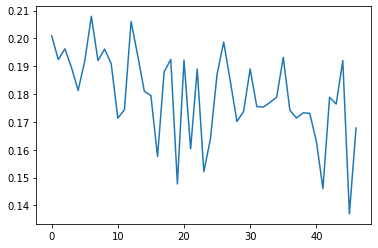

In [67]:
plt.plot(nn4_small2_train.history.history["loss"])
plt.show()

As we don't have enough images (10k) and calculation ressources, we will use a pretrained network, trained by the OpenFace project. We take the pre-trained model nn4.small2. This model is trained with 500k images and has 3.74 millions of parameters. The model can be downloaded [here](https://cmusatyalab.github.io/openface/models-and-accuracies/#model-definitions).

This model has an AUC of 0.973 ([source](https://cmusatyalab.github.io/openface/models-and-accuracies/#projects-with-higher-accuracy)):
![nn4_small2 AUC](images_illustation/nn4small2-auc.png)

In [52]:
nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('./weights/nn4.small2.v1.h5')

## 2.3. Create the embedding of each face

In [68]:
metadata = load_metadata('images')
embedded = np.zeros((metadata.shape[0], EMBEDDING_VECTOR_SIZE))

for i, m in enumerate(metadata):
    # load the image, and crop the face
    img = load_image(m.image_path()) 
    img_aligned = al.align(imgDim=FACE_IMG_SIZE, rgbImg=img, landmarkIndices=OUTER_EYES_AND_NOSE)
    # scale RGB values to interval [0,1]
    img_aligned = np.asarray(img_aligned, dtype=np.float32)/255 # Quand ça marchait je crois que cette ligne était décommenté
    # compute the embedding vector for image
    # np.expand_dims() is used to add a dimension
    embedded[i] = nn4_small2.predict(np.expand_dims(img_aligned, axis=0)) 

# 3. Face recognition

We will now build a model to classify a face as being one person, by comparison to the faces we have in database. 

## 3.1. Face recognition by distance treshold

The first approach is to compute a distance between the new face and all the known faces in the database. If the distance is below a treshold, the two compared faces belong to the same person. The distance is an euclidean distance and it is computed on the embeddings of the faces:

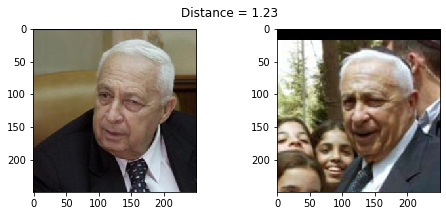

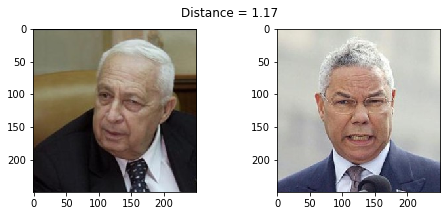

In [69]:
def distance(emb1, emb2):
    """ compute the euclidian distance between the vectors emb1 and emb2 """ 
    return np.sum(np.square(emb1 - emb2)) 

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()))  

show_pair(2, 3)
show_pair(2, 27)

We display the clusters between each images of our dataset, by reducing the dimensions to 2 dimensions with the t-SNE algorithm:

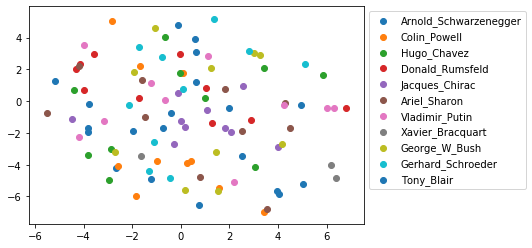

In [70]:
from sklearn.manifold import TSNE

targets = np.array([m.name for m in metadata])
X_embedded = TSNE(n_components=2).fit_transform(embedded)

for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));

We compute the distance to which two faces are considered reprensenting 2 different persons. To do so, we compute the F1-score and the accuracy for multiple tresholds, and keep the one with the best F1-score:

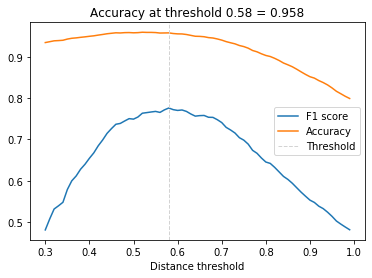

In [56]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata)
for i in range(num - 1):
    for j in range(1, num):
        dist = distance(embedded[i], embedded[j]) ## compute the distance between the embedding vectors i and j
        distances.append(dist)
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)
# make a list of possible thresholds between 0.3 and 1.0, by steps of 0.01
thresholds = np.arange(0.3, 1.0, 0.01) 

# For each possible threshold:
# distances < threshold returns a vector of booleans: for each dist in distances, the boolean says if the dist is below the threshold
# f1_score(identical, distances < threshold) returns the f1_score between the "ground truth" (the vector called 'identical') and the results
#    found by using the specific threshold called 'threshold'
f1_scores = [f1_score(identical, distances < threshold) for threshold in thresholds]
acc_scores = [accuracy_score(identical, distances < threshold) for threshold in thresholds]

# get the indice of the best treshold
opt_idx = np.argmax(f1_scores)
# get the threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# compute the accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

We display the repartition of the distances between positive pairs and between negative pairs. The treshold found above shows how many pairs are well classified:

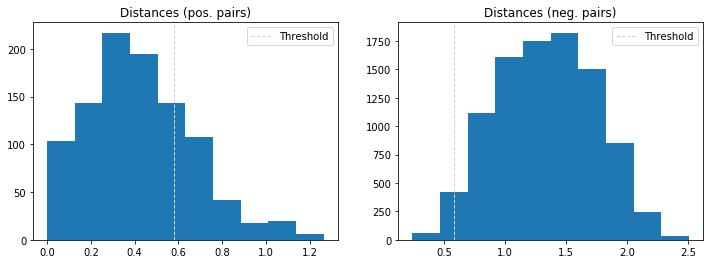

In [57]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='coral', label='Threshold')
plt.title('Distances (pos. pairs)')
plt.legend();
plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='coral', label='Threshold') #lightgrey
plt.title('Distances (neg. pairs)')
plt.legend();

If this model is a good approach, with an accuracy of 95.8%, we can do better with a classification model.

## 3.2. Face recognition with a KNN or a SVM:

We will train a KNN model and a SVM one to classify the faces:

In [58]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

# get the names of the persons of the dataset and encode them
targets = np.array([m.name for m in metadata])
encoder = LabelEncoder() 
y = encoder.fit(targets)
y = encoder.transform(targets)

# build a train and test sets
train_idx = np.arange(metadata.shape[0]) % 2 != 0
test_idx = np.arange(metadata.shape[0]) % 2 == 0
X_train = embedded[train_idx]
X_test = embedded[test_idx]
y_train = y[train_idx]
y_test = y[test_idx]

# Create and fit a KNN and a SVM model
knn= KNeighborsClassifier(n_neighbors=1, metric='euclidean')
knn.fit(X_train, y_train)
svc = LinearSVC()
svc.fit(X_train, y_train)

# Compute the accuracy scores
acc_knn = accuracy_score(y_test, knn.predict(X_test))
acc_svc = accuracy_score(y_test, svc.predict(X_test))
print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

KNN accuracy = 0.9615384615384616, SVM accuracy = 0.9807692307692307


The SVM gives a slightly better score. We will keep it and use it to classify a new face that is not in the train set:

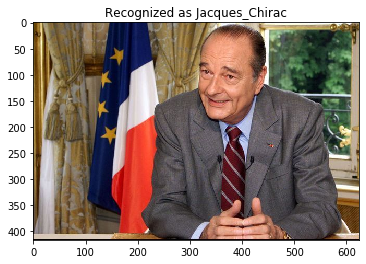

In [64]:
# Load a new image
new_img = load_image("./custom_images/jacques_chirac_bureau.jpg")
new_img_aligned = al.align(imgDim=FACE_IMG_SIZE, rgbImg=new_img, landmarkIndices=OUTER_EYES_AND_NOSE)
new_img_aligned = np.asarray(new_img_aligned, dtype=np.float32)/255 
new_img_embedded = nn4_small2_pretrained.predict(np.expand_dims(new_img_aligned, axis=0)) 

# Predict its name
example_prediction = svc.predict([new_img_embedded])
example_identity = encoder.inverse_transform(example_prediction)[0]

plt.imshow(new_img)
plt.title(f'Recognized as {example_identity}');